# Custom Data Generation

While we already have numerous data modalities commonly used for robot learning ready, we also provide several helper functions 

In [1]:
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt

# metadata, change this to your own configuration
data_path = "/scr/behavior"
task_id = 0
demo_id = 10

## 1. Generate colored point cloud from RGBD videos

In [2]:
import h5py
import torch as th
from omnigibson.learning.utils.obs_utils import color_pcd_vis, rgbd_vid_to_pcd

In [3]:
rgbd_vid_to_pcd(
    data_folder=data_path,
    task_id=task_id,
    demo_id=demo_id,
    episode_id=0,
    pcd_range=(-0.2, 1.5, -1.5, 1.5, 0.2, 1.5),
    batch_size=1000,
    use_fps=True,
)

Processing fused point cloud from observations...
Downsampling point cloud to 4096 points using FPS
Processing fused point cloud from observations...
Downsampling point cloud to 4096 points using FPS


#### Now, we load the generated point cloud from the disk

In [4]:
f_pcd_vid = h5py.File(f"{data_path}/pcd_vid/task-{task_id:04d}/episode_{demo_id:08d}.hdf5", "r", libver="latest", swmr=True)
pcd_vid = f_pcd_vid["data/demo_0/robot_r1::fused_pcd"][:]
print(pcd_vid.shape)

(1956, 4096, 6)


We now visualize the point cloud with `color_pcd_vis`, which will spawn an Open3D window and visualize the point cloud through time.

In [5]:
color_pcd_vis(pcd_vid)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 1956/1956 [00:32<00:00, 59.94it/s]


## 2. Obtain coarse semantic data from seg_instance_id

`seg_instance_id` refers to mesh level segmentation (i.e. each mesh is a separate instance). We store this in our dataset as it is the finest level of semantic info available. We can resconstruct coarser semantic infos from seg_instance_id, including `instance segmentation`, `semantic segmentation`, `bounding box`, etc.


In [6]:
from omnigibson.learning.utils.obs_utils import OBS_LOADER_MAP, instance_id_to_instance, instance_to_semantic, instance_to_bbox, overlay_bboxes_with_names

with open(f"{data_path}/2025-challenge-demos/meta/episodes/task-{task_id:04d}/episode_{demo_id:08d}.json", "r") as f:
    meta = json.load(f)
    unique_ins_ids = meta["robot_r1::robot_r1:zed_link:Camera:0::unique_ins_ids"]
    instance_id_mapping = json.loads(meta["ins_id_mapping"])
    instance_id_mapping = {int(k): v for k, v in instance_id_mapping.items()}
seg_instance_id = OBS_LOADER_MAP["seg_instance_id"](
    data_path=f"{data_path}/2025-challenge-demos",
    task_id=task_id,
    demo_id=f"{demo_id:08d}",
    camera_id="head",
    output_size=(720, 720),
    id_list=th.tensor(unique_ins_ids),
).frames.numpy()[1000]

In [7]:
# convert to instance segmentation from mesh segmentation
seg_instance, instance_mapping = instance_id_to_instance(
    obs=th.from_numpy(seg_instance_id),
    instance_id_mapping=instance_id_mapping,
    unique_ins_ids=np.array(unique_ins_ids),
)

Now, we continue to convert to semantic segmentation. 
Note that we can get the semantic classname by querying `omnigibson.utils.constants.semantic_class_name_to_id`

In [8]:
# convert to semantic segmentation from instance segmentation
seg_semantic = instance_to_semantic(
    obs=seg_instance,
    instance_mapping=instance_mapping,
    unique_ins_ids=np.array(list(instance_mapping.keys())),
    is_instance_id=False,
)

# we can also directly convert to semantic using seg_instance_id
seg_semantic_direct = instance_to_semantic(
    obs=th.from_numpy(seg_instance_id),
    instance_mapping=instance_id_mapping,
    unique_ins_ids=np.array(unique_ins_ids),
    is_instance_id=True
)

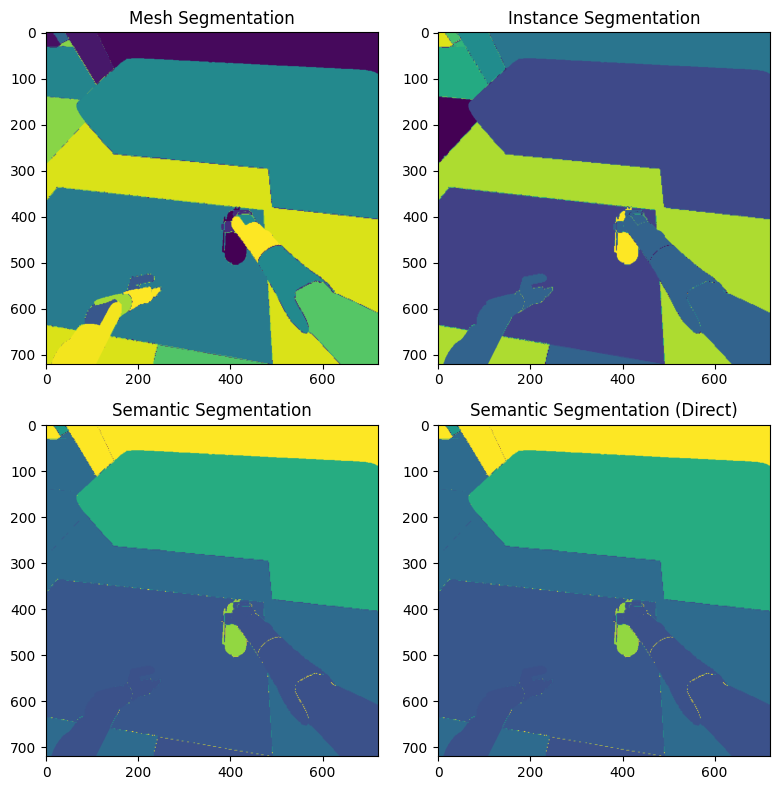

In [14]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(seg_instance_id)
plt.title(f"Mesh Segmentation")

plt.subplot(2, 2, 2)
plt.imshow(seg_instance)
plt.title(f"Instance Segmentation")

plt.subplot(2, 2, 3)
plt.imshow(seg_semantic)
plt.title(f"Semantic Segmentation")

plt.subplot(2, 2, 4)
plt.imshow(seg_semantic_direct / 255.0)
plt.title(f"Semantic Segmentation (Direct)")

plt.tight_layout()
plt.show()

In [ ]:
# convert to bounding box
# NOTE: due to compression loss from mp4 video, the bounding boxes might have large deviations from ground truth values
# This is just a demonstration of how to construct bounding boxes from instance segmentation
# You should always use ground truth instance segmentations to get accurate bounding boxes
bbox = instance_to_bbox(
    obs=seg_instance,
    instance_mapping=instance_mapping,
    unique_ins_ids=set(instance_mapping.keys()),
)
for b in bbox[0]:
    print(b)

(0, 7, 627, 719, 3)
(18, 30, 101, 147, 4)
(8, 0, 509, 504, 5)
(87, 196, 707, 457, 7)
(0, 338, 491, 719, 11)
(6, 30, 719, 434, 12)
(16, 4, 571, 719, 13)
(17, 5, 381, 427, 14)
(150, 472, 481, 718, 15)
(0, 0, 719, 719, 16)
(16, 2, 47, 24, 17)
(111, 2, 445, 413, 18)
(67, 0, 719, 504, 19)
(42, 0, 627, 635, 23)
(30, 11, 446, 428, 24)
(104, 108, 105, 109, 27)
(0, 32, 107, 146, 28)
(0, 66, 601, 711, 29)
(0, 18, 629, 715, 30)
(16, 0, 418, 379, 32)
(0, 2, 595, 713, 33)
(6, 20, 490, 698, 35)
(0, 4, 434, 609, 38)
(0, 196, 719, 719, 39)
(0, 0, 595, 673, 42)
(15, 0, 434, 605, 44)


### Utilizing the data replay file

If you would like to get some more additional information for data replay. You can utilize our data replay file located at `OmniGibson/scripts/replay_obs.py`.

The scipt will take in a episode raw file (located [here](https://huggingface.co/datasets/behavior-1k/2025-challenge-rawdata)), and replay the whole trajectory and generate observations based on the argument provided.